# Experiment2 결과
실험 조건
- dataset: VocDetection2
- loss: YoloLoss2

In [1]:
import sys, os
sys.path.append('../YOLOv1')

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import cv2

from dataset import VOCDataset
from model import YOLOv1
from loss import YoloLoss1, YoloLoss2
from trainer import Trainer
from config import config

config = config()

config.batch_size = 16
config.lr = 2e-5
config.device='cuda'

config.print_interval = 50
config.model_dir = '../checkpoints/experiment2'
config.load_model_path = os.path.join(config.model_dir, 'YOLOv1_180epoch.pt')

config.dataset_dir = r'D:\AI\Dataset\VocDetection2'
config.img_dir = os.path.join(config.dataset_dir, 'images')
config.label_dir = os.path.join(config.dataset_dir, 'labels')
config.train_csv = os.path.join(config.dataset_dir, 'train.csv')
config.valid_csv = os.path.join(config.dataset_dir, 'valid.csv')

config.save_csv_path = os.path.join(config.model_dir, 'YOLOv1_result.csv')

train_dataset = VOCDataset(
    config.train_csv,
    config.img_dir,
    config.label_dir,
    config.img_size,
    config.S, config.B, config.C,
    config.test_transform,
    return_img_path=True,
)
valid_dataset = VOCDataset(
    config.valid_csv,
    config.img_dir,
    config.label_dir,
    config.img_size,
    config.S, config.B, config.C,
    config.test_transform,
    return_img_path=True,
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    drop_last=False,
)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    drop_last=False,
)

model = YOLOv1(config.S, config.B, config.C).to(config.device)
optimizer = optim.Adam(model.parameters(), config.lr)
crit = YoloLoss2(config.S, config.B, config.C)
trainer = Trainer(model, optimizer, crit)

# Train/Valid loss

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(config.save_csv_path)

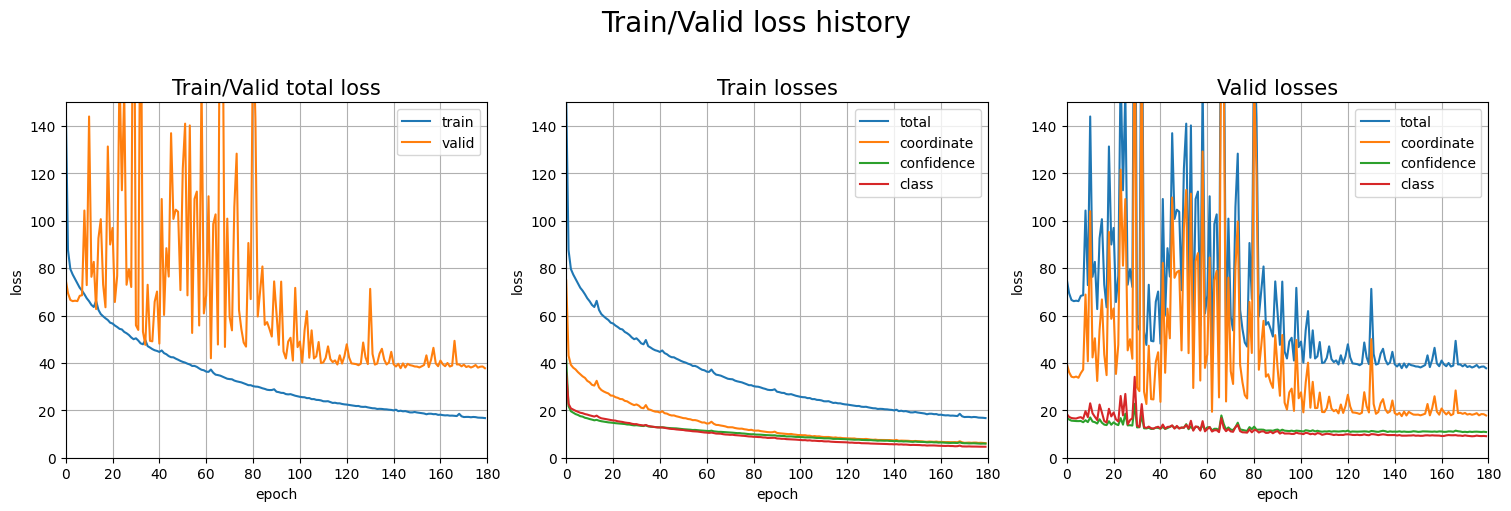

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15,5), constrained_layout=True)
plt.suptitle('Train/Valid loss history\n', fontsize=20)
xlim = [0, 180]
ylim = [0, 150]

axes[0].plot(df['train_loss'])
axes[0].plot(df['valid_loss'])
axes[0].set_xlabel('epoch', fontsize=10)
axes[0].set_ylabel('loss', fontsize=10)
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[0].set_title('Train/Valid total loss', fontsize=15)
axes[0].legend(['train', 'valid'])
axes[0].grid(True, axis='both')



axes[1].plot(df['train_loss'])
axes[1].plot(df['train_loss_coord'])
axes[1].plot(df['train_loss_conf'])
axes[1].plot(df['train_loss_cls'])
axes[1].set_xlabel('epoch', fontsize=10)
axes[1].set_ylabel('loss', fontsize=10)
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)
axes[1].set_title('Train losses', fontsize=15)
axes[1].legend(['total', 'coordinate', 'confidence', 'class'])
axes[1].grid(True, axis='both')



axes[2].plot(df['valid_loss'])
axes[2].plot(df['valid_loss_coord'])
axes[2].plot(df['valid_loss_conf'])
axes[2].plot(df['valid_loss_cls'])
axes[2].set_xlabel('epoch', size=10)
axes[2].set_ylabel('loss', size=10)
axes[2].set_xlim(xlim)
axes[2].set_ylim(ylim)
axes[2].set_title('Valid losses', fontsize=15)
axes[2].legend(['total', 'coordinate', 'confidence', 'class'])
axes[2].grid(True, axis='both')

- 60 epoch에서부터 과적합 발생하여 train/valid 간 loss 격차 발생

# AP/mAP

In [4]:
class_names = config.voc_classes

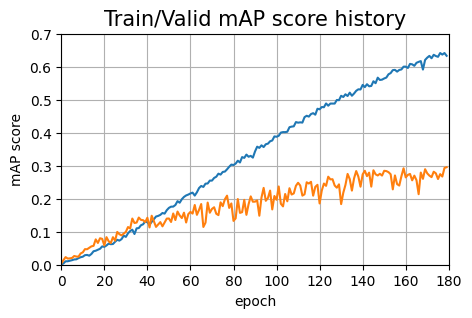

In [5]:
xlim = [0, 180]
ylim = [0, 0.7]

plt.figure(figsize=(5, 3))
plt.plot(df['train_mAP'])
plt.plot(df['valid_mAP'])
plt.xlabel('epoch', fontsize=10)
plt.ylabel('mAP score', fontsize=10)
plt.title('Train/Valid mAP score history', fontsize=15)
plt.xlim(xlim)
plt.ylim(ylim)
plt.grid(True)

- 40 ~ 60 epoch 사이에서 mAP score가 벌어지기 시작함
- 최종적으로 train dataset에 대해 mAP 0.63 valid dataset에 대해 mAP 0.30에 수렴

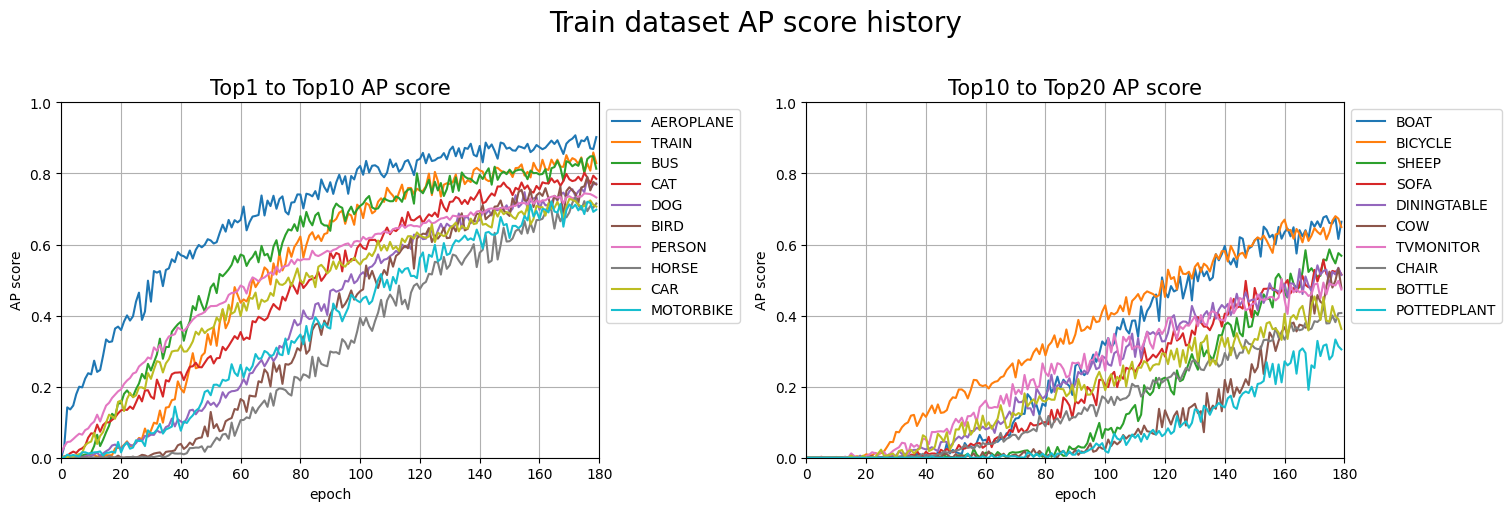

In [6]:
# 마지막 epoch 기준 train dataset AP score 내림차순 정렬
indices = np.argsort(df.iloc[-1, 5:25].values)[::-1]

fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
plt.suptitle('Train dataset AP score history\n', fontsize=20)
xlim = [0, 180]
ylim = [0, 1]

legend = []
for i in indices[:10]:
    axes[0].plot(df.iloc[:, 5+i])
    legend.append(class_names[i])

axes[0].set_xlabel('epoch', fontsize=10)
axes[0].set_ylabel('AP score', fontsize=10)
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[0].set_title('Top1 to Top10 AP score', fontsize=15)
axes[0].legend(legend, loc='upper left', bbox_to_anchor=(1.0, 1.0))
axes[0].grid(True, axis='both')

legend = []
for i in indices[10:20]:
    axes[1].plot(df.iloc[:, 5+i])
    legend.append(class_names[i])

axes[1].set_xlabel('epoch', fontsize=10)
axes[1].set_ylabel('AP score', fontsize=10)
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)
axes[1].set_title('Top10 to Top20 AP score', fontsize=15)
axes[1].legend(legend, loc='upper left', bbox_to_anchor=(1.0, 1.0))
axes[1].grid(True, axis='both')

- 클래스 간에 AP score 차이가 꽤 나는편으로 비행기 클래스는 0.9 식물 클래스는 0.3에 수렴

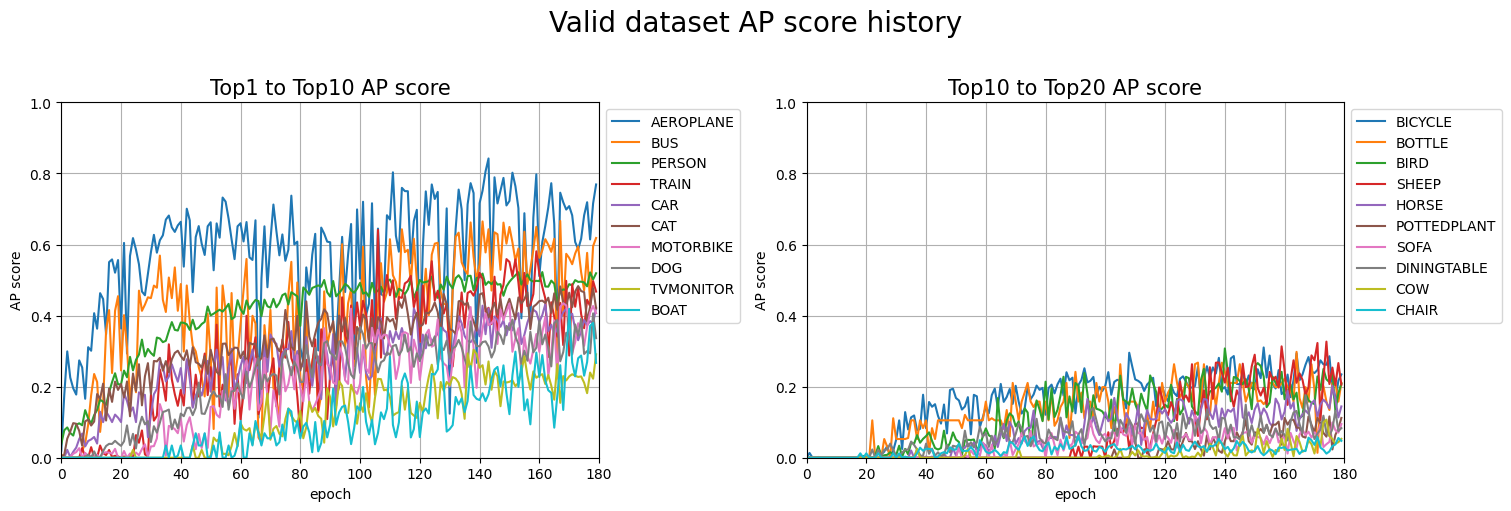

In [7]:
# 마지막 epoch 기준 train dataset AP score 내림차순 정렬
indices = np.argsort(df.iloc[-1, 30:50].values)[::-1]

fig, axes = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
plt.suptitle('Valid dataset AP score history\n', fontsize=20)
xlim = [0, 180]
ylim = [0, 1]

legend = []
for i in indices[:10]:
    axes[0].plot(df.iloc[:, 30+i])
    legend.append(class_names[i])

axes[0].set_xlabel('epoch', fontsize=10)
axes[0].set_ylabel('AP score', fontsize=10)
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[0].set_title('Top1 to Top10 AP score', fontsize=15)
axes[0].legend(legend, loc='upper left', bbox_to_anchor=(1.0, 1.0))
axes[0].grid(True, axis='both')

legend = []
for i in indices[10:20]:
    axes[1].plot(df.iloc[:, 30+i])
    legend.append(class_names[i])

axes[1].set_xlabel('epoch', fontsize=10)
axes[1].set_ylabel('AP score', fontsize=10)
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)
axes[1].set_title('Top10 to Top20 AP score', fontsize=15)
axes[1].legend(legend, loc='upper left', bbox_to_anchor=(1.0, 1.0))
axes[1].grid(True, axis='both')

- AP score가 수렴하지 못하고 학습 내내 크게 진동하는 것을 보여줌

# Train dataset 결과 분석

In [93]:
# losses, pred_bboxes, true_bboxes, img_paths = trainer.test(train_loader, config)
losses, pred_bboxes, true_bboxes, img_paths = trainer.test(valid_loader, config)




now loading.....
resume epoch: 181 lowest loss: 37.78397787184942

[1/85] test loss: 33.0392
[51/85] test loss: 34.7902


## Loss

In [94]:
print(f'total loss: {losses[0]:.4f}')
print(f'coordinate loss: {losses[1]:.4f}')
print(f'confidence loss: {losses[2]:.4f}')
print(f'class loss: {losses[3]:.4f}')

total loss: 37.3628
coordinate loss: 17.6318
confidence loss: 10.7339
class loss: 8.9971


## AP/mAP

In [95]:
import sys, os
sys.path.append('../YOLOv1')

from utils import mAP

average_precisions, mean_average_precision = mAP(pred_bboxes, true_bboxes, config.iou_threshold, config.num_classes)

In [96]:
print('mAP:', mean_average_precision)
for class_name, ap in zip(class_names, average_precisions):
    print(f'{class_name}: {ap:.2f}')

mAP: 0.29621583614498376
AEROPLANE: 0.77
BICYCLE: 0.23
BIRD: 0.21
BOAT: 0.27
BOTTLE: 0.21
BUS: 0.62
CAR: 0.41
CAT: 0.42
CHAIR: 0.05
COW: 0.05
DININGTABLE: 0.08
DOG: 0.34
HORSE: 0.14
MOTORBIKE: 0.41
PERSON: 0.52
POTTEDPLANT: 0.11
SHEEP: 0.22
SOFA: 0.09
TRAIN: 0.47
TVMONITOR: 0.29


## Error 분석

In [97]:
import sys, os
sys.path.append('../YOLOv1')

from utils import analyze_error

csv_path = './experiment2_error_analysis.csv'
analyze_error(pred_bboxes, true_bboxes, img_paths, csv_path)

In [98]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(csv_path)
df.head(5)

,img_path,train_idx,gt_class,gt_conf,gt_x,gt_y,gt_w,gt_h,dt_class,dt_conf,dt_x,dt_y,dt_w,dt_h,iou,error_type
0,D:\AI\Dataset\VocDetection2\images\2010_004139...,0.0,18.0,0.800587,0.497183,0.524932,0.956103,0.632734,18.0,0.800587,0.497183,0.524932,0.956103,0.632734,0.000000,background
1,D:\AI\Dataset\VocDetection2\images\2010_004139...,0.0,6.0,1.000000,0.504000,0.507000,0.988000,0.620000,6.0,1.000000,0.504000,0.507000,0.988000,0.620000,0.000000,not detected
2,D:\AI\Dataset\VocDetection2\images\2008_001219...,1.0,14.0,1.000000,0.498000,0.508000,0.466000,0.984000,14.0,0.878018,0.483580,0.504660,0.444627,0.975932,0.852593,correct
3,D:\AI\Dataset\VocDetection2\images\2008_005147...,2.0,1.0,1.000000,0.582000,0.481000,0.688000,0.412000,1.0,0.579058,0.610995,0.466914,0.608621,0.365673,0.562821,correct
4,D:\AI\Dataset\VocDetection2\images\2011_005625...,3.0,14.0,1.000000,0.726000,0.692000,0.256000,0.366000,14.0,0.785115,0.471249,0.633887,0.521246,0.496454,0.509620,correct


In [99]:
class_names = config.voc_classes

# i, j 좌표 추가
df['gt_i'] = (7 * df['gt_y']).astype(int)
df['gt_j'] = (7 * df['gt_x']).astype(int)
df['dt_i'] = (7 * df['dt_y']).astype(int)
df['dt_j'] = (7 * df['dt_x']).astype(int)

# class label -> class name
for i in range(len(df)):
    df.loc[i, 'gt_class_name'] = class_names[int(df.loc[i, 'gt_class'])]
    df.loc[i, 'dt_class_name'] = class_names[int(df.loc[i, 'dt_class'])]
    
df.head(5)

,img_path,train_idx,gt_class,gt_conf,gt_x,gt_y,gt_w,gt_h,dt_class,dt_conf,...,dt_w,dt_h,iou,error_type,gt_i,gt_j,dt_i,dt_j,gt_class_name,dt_class_name
0,D:\AI\Dataset\VocDetection2\images\2010_004139...,0.0,18.0,0.800587,0.497183,0.524932,0.956103,0.632734,18.0,0.800587,...,0.956103,0.632734,0.000000,background,3,3,3,3,TRAIN,TRAIN
1,D:\AI\Dataset\VocDetection2\images\2010_004139...,0.0,6.0,1.000000,0.504000,0.507000,0.988000,0.620000,6.0,1.000000,...,0.988000,0.620000,0.000000,not detected,3,3,3,3,CAR,CAR
2,D:\AI\Dataset\VocDetection2\images\2008_001219...,1.0,14.0,1.000000,0.498000,0.508000,0.466000,0.984000,14.0,0.878018,...,0.444627,0.975932,0.852593,correct,3,3,3,3,PERSON,PERSON
3,D:\AI\Dataset\VocDetection2\images\2008_005147...,2.0,1.0,1.000000,0.582000,0.481000,0.688000,0.412000,1.0,0.579058,...,0.608621,0.365673,0.562821,correct,3,4,3,4,BICYCLE,BICYCLE
4,D:\AI\Dataset\VocDetection2\images\2011_005625...,3.0,14.0,1.000000,0.726000,0.692000,0.256000,0.366000,14.0,0.785115,...,0.521246,0.496454,0.509620,correct,4,5,4,3,PERSON,PERSON


In [100]:
tensor_true_bboxes = torch.zeros(len(true_bboxes), 7)
for i, bbox in enumerate(true_bboxes):
    tensor_true_bboxes[i] = bbox

t = torch.zeros(tensor_true_bboxes.shape[0], 22)
t[:, 1:8] = tensor_true_bboxes

In [101]:
t_df = pd.DataFrame(columns=df.columns, data=t)

t_df['error_type'] = 'target'

# i, j 좌표 추가
t_df['gt_i'] = (7 * t_df['gt_y']).astype(int)
t_df['gt_j'] = (7 * t_df['gt_x']).astype(int)

# class label -> class name
for i in range(len(t_df)):
    t_df.loc[i, 'gt_class_name'] = class_names[int(t_df.loc[i, 'gt_class'])]

t_df

,img_path,train_idx,gt_class,gt_conf,gt_x,gt_y,gt_w,gt_h,dt_class,dt_conf,...,dt_w,dt_h,iou,error_type,gt_i,gt_j,dt_i,dt_j,gt_class_name,dt_class_name
0,0.0,0.0,6.0,1.0,0.504000,0.507000,0.988000,0.620000,0.0,0.0,...,0.0,0.0,0.0,target,3,3,0.0,0.0,CAR,0.0
1,0.0,1.0,14.0,1.0,0.498000,0.508000,0.466000,0.984000,0.0,0.0,...,0.0,0.0,0.0,target,3,3,0.0,0.0,PERSON,0.0
2,0.0,2.0,1.0,1.0,0.582000,0.481000,0.688000,0.412000,0.0,0.0,...,0.0,0.0,0.0,target,3,4,0.0,0.0,BICYCLE,0.0
3,0.0,3.0,14.0,1.0,0.726000,0.692000,0.256000,0.366000,0.0,0.0,...,0.0,0.0,0.0,target,4,5,0.0,0.0,PERSON,0.0
4,0.0,4.0,14.0,1.0,0.293000,0.646000,0.330000,0.458000,0.0,0.0,...,0.0,0.0,0.0,target,4,2,0.0,0.0,PERSON,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1842,0.0,1344.0,14.0,1.0,0.486017,0.461000,0.633218,0.838000,0.0,0.0,...,0.0,0.0,0.0,target,3,3,0.0,0.0,PERSON,0.0
1843,0.0,1345.0,7.0,1.0,0.405000,0.546000,0.310000,0.346000,0.0,0.0,...,0.0,0.0,0.0,target,3,2,0.0,0.0,CAT,0.0
1844,0.0,1346.0,14.0,1.0,0.503000,0.520000,0.444000,0.960000,0.0,0.0,...,0.0,0.0,0.0,target,3,3,0.0,0.0,PERSON,0.0
1845,0.0,1347.0,15.0,1.0,0.778000,0.707000,0.376000,0.336000,0.0,0.0,...,0.0,0.0,0.0,target,4,5,0.0,0.0,POTTEDPLANT,0.0


In [102]:
df = pd.concat([df, t_df])
df

,img_path,train_idx,gt_class,gt_conf,gt_x,gt_y,gt_w,gt_h,dt_class,dt_conf,...,dt_w,dt_h,iou,error_type,gt_i,gt_j,dt_i,dt_j,gt_class_name,dt_class_name
0,D:\AI\Dataset\VocDetection2\images\2010_004139...,0.0,18.0,0.800587,0.497183,0.524932,0.956103,0.632734,18.0,0.800587,...,0.956103,0.632734,0.000000,background,3,3,3.0,3.0,TRAIN,TRAIN
1,D:\AI\Dataset\VocDetection2\images\2010_004139...,0.0,6.0,1.000000,0.504000,0.507000,0.988000,0.620000,6.0,1.000000,...,0.988000,0.620000,0.000000,not detected,3,3,3.0,3.0,CAR,CAR
2,D:\AI\Dataset\VocDetection2\images\2008_001219...,1.0,14.0,1.000000,0.498000,0.508000,0.466000,0.984000,14.0,0.878018,...,0.444627,0.975932,0.852593,correct,3,3,3.0,3.0,PERSON,PERSON
3,D:\AI\Dataset\VocDetection2\images\2008_005147...,2.0,1.0,1.000000,0.582000,0.481000,0.688000,0.412000,1.0,0.579058,...,0.608621,0.365673,0.562821,correct,3,4,3.0,4.0,BICYCLE,BICYCLE
4,D:\AI\Dataset\VocDetection2\images\2011_005625...,3.0,14.0,1.000000,0.726000,0.692000,0.256000,0.366000,14.0,0.785115,...,0.521246,0.496454,0.509620,correct,4,5,4.0,3.0,PERSON,PERSON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1842,0.0,1344.0,14.0,1.000000,0.486017,0.461000,0.633218,0.838000,0.0,0.000000,...,0.000000,0.000000,0.000000,target,3,3,0.0,0.0,PERSON,0.0
1843,0.0,1345.0,7.0,1.000000,0.405000,0.546000,0.310000,0.346000,0.0,0.000000,...,0.000000,0.000000,0.000000,target,3,2,0.0,0.0,CAT,0.0
1844,0.0,1346.0,14.0,1.000000,0.503000,0.520000,0.444000,0.960000,0.0,0.000000,...,0.000000,0.000000,0.000000,target,3,3,0.0,0.0,PERSON,0.0
1845,0.0,1347.0,15.0,1.000000,0.778000,0.707000,0.376000,0.336000,0.0,0.000000,...,0.000000,0.000000,0.000000,target,4,5,0.0,0.0,POTTEDPLANT,0.0


### 분류 별 에러 개수

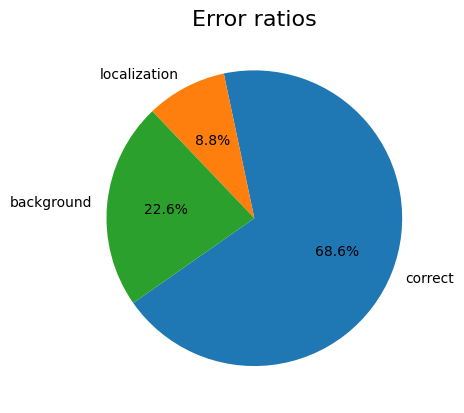

In [103]:
error_types = ['correct', 'localization', 'background']
data = [len(df[df['error_type'] == error_type]) for error_type in error_types]

plt.pie(data, labels=error_types, autopct='%.1f%%', startangle=215)
plt.title('Error ratios', fontsize=16)
plt.show()

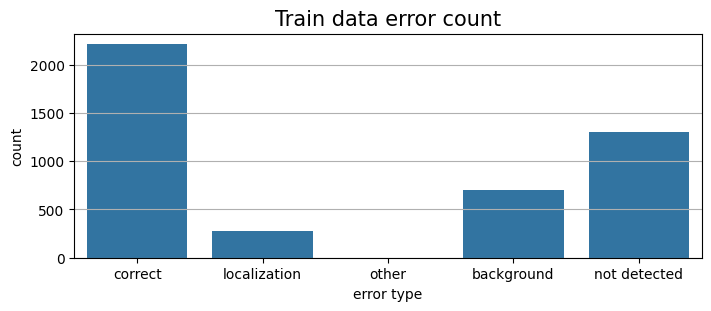

In [104]:
fig, axes = plt.subplots(1, figsize=(7,3), constrained_layout=True)
order = ['correct', 'localization', 'other', 'background', 'not detected']

sns.countplot(x=df['error_type'], order=order, ax=axes)
axes.set_xlabel('error type', fontsize=10)
axes.set_ylabel('count', fontsize=10)
axes.set_title('Train data error count', fontsize=15)
axes.grid(True, axis='y')

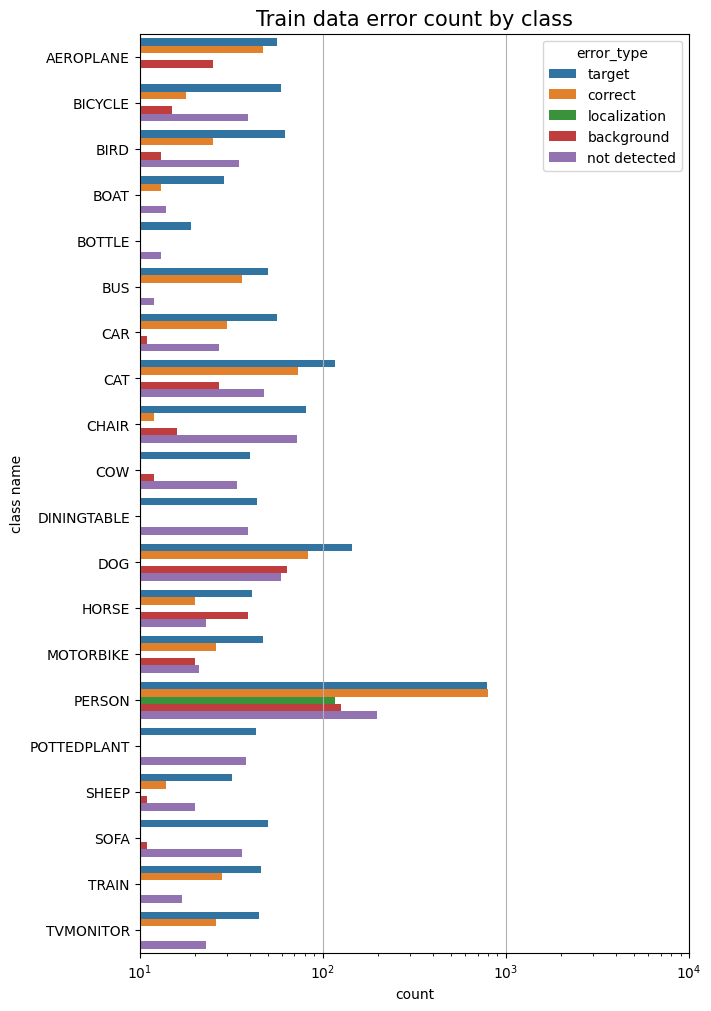

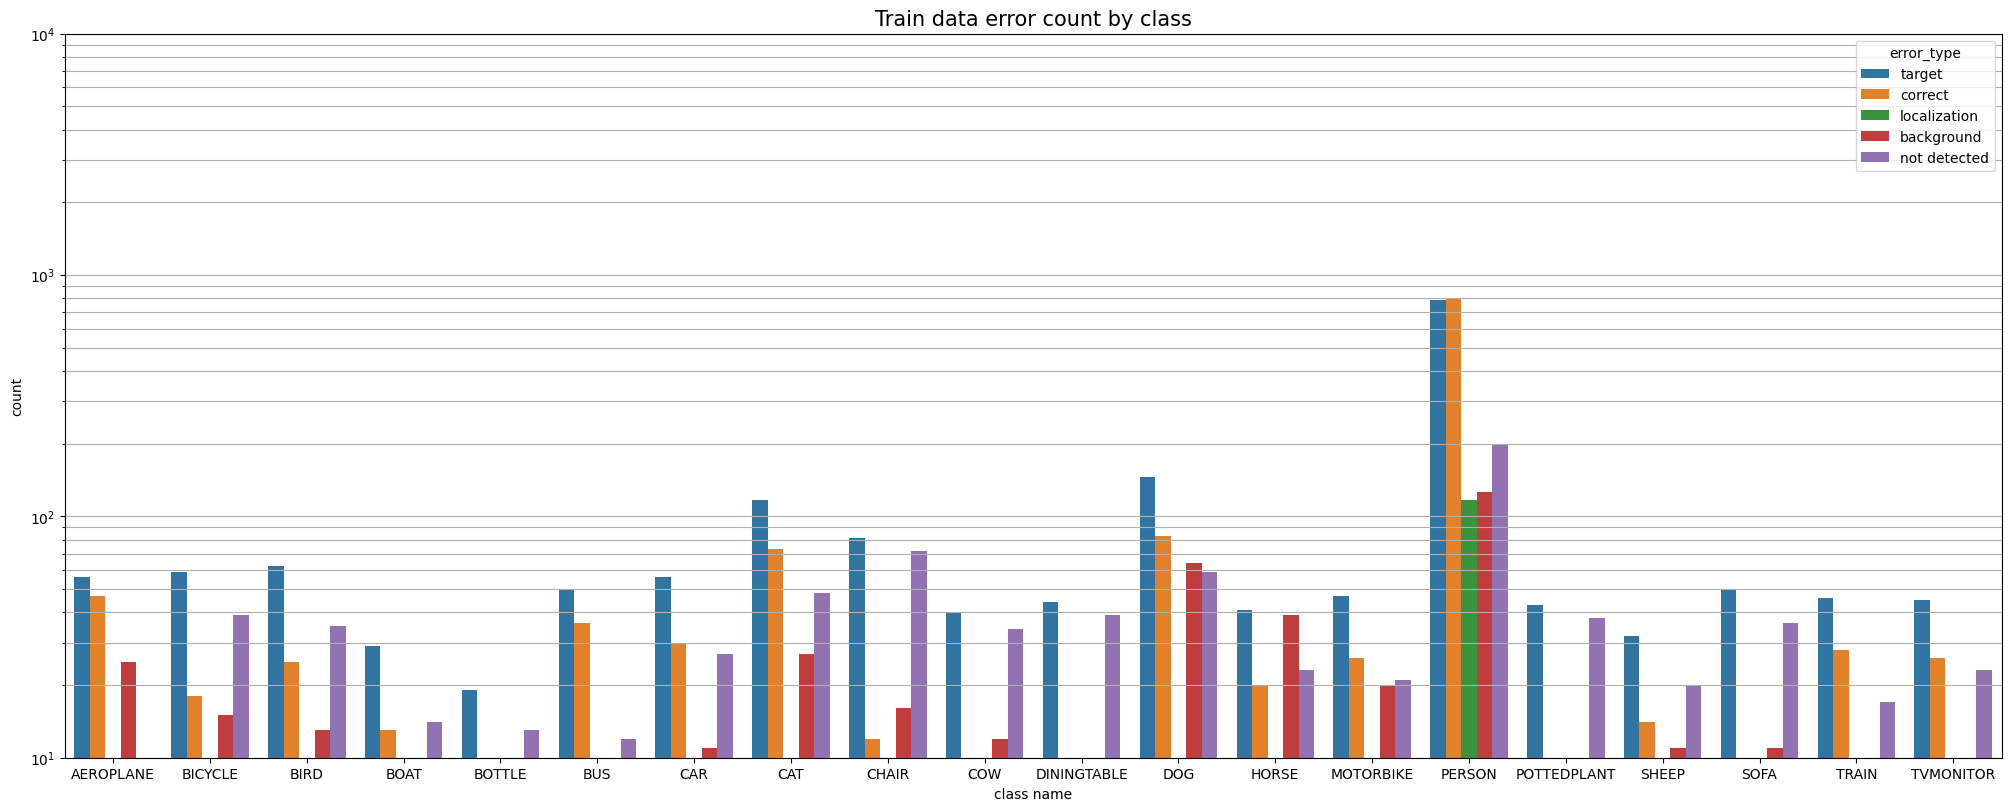

In [105]:
# 가로로 보기
hue_order = ['target', 'correct', 'localization', 'background', 'not detected']
order = class_names

fig, axes = plt.subplots(1, figsize=(7,10), constrained_layout=True)
xlim = [1e1, 1e4]

sns.countplot(data=df, y='gt_class_name', hue='error_type', hue_order=hue_order, order=order, ax=axes)
axes.set_xscale('log')
axes.set_xlabel('count', fontsize=10)
axes.set_ylabel('class name', fontsize=10)
axes.set_xlim(xlim)
axes.set_title('Train data error count by class', fontsize=15)
axes.grid(True, axis='x')


# 세로로 보기
hue_order = ['target', 'correct', 'localization', 'background', 'not detected']
order = class_names

fig, axes = plt.subplots(1, figsize=(20,8), constrained_layout=True)
ylim = [1e1, 1e4]

sns.countplot(data=df, x='gt_class_name', hue='error_type', hue_order=hue_order, order=order, ax=axes)
axes.set_yscale('log')
axes.set_ylabel('count', fontsize=10)
axes.set_xlabel('class name', fontsize=10)
axes.set_ylim(ylim)
axes.set_title('Train data error count by class', fontsize=15)
axes.grid(True, axis='y', which='both')

## bbox 폭에 의한 분포 확인

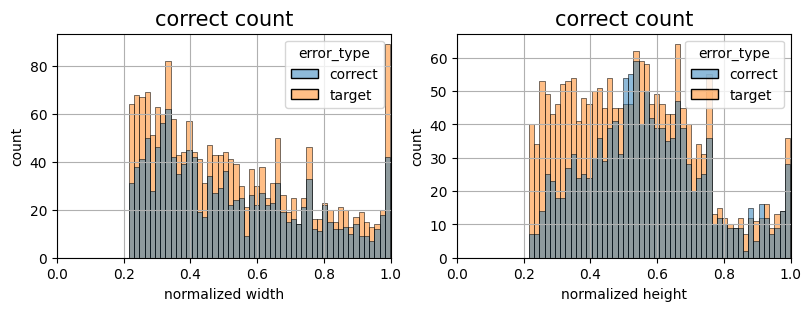

In [111]:
selected_column = 'correct' # 'correct', 'localization', 'background', 'not detected' 중 택1

hue_order = ['target', selected_column]
order = class_names

temp_df = df[(df['error_type'] == selected_column) | (df['error_type'] == 'target')] # 총 ground truth 대비 selected_column 시각화
fig, axes = plt.subplots(1, 2, figsize=(8,3), constrained_layout=True)
xlim = [0, 1]

sns.histplot(data=temp_df, x='gt_w', bins=50, hue='error_type', ax=axes[0])
axes[0].set_xlabel('normalized width', fontsize=10)
axes[0].set_ylabel('count', fontsize=10)
axes[0].set_xlim(xlim)
axes[0].set_title(f'{selected_column} count', fontsize=15)
axes[0].grid(True, axis='both')

sns.histplot(data=temp_df, x='gt_h', bins=50, hue='error_type', ax=axes[1])
axes[1].set_xlabel('normalized height', fontsize=10)
axes[1].set_ylabel('count', fontsize=10)
axes[1].set_xlim(xlim)
axes[1].set_title(f'{selected_column} count', fontsize=15)
axes[1].grid(True, axis='both')

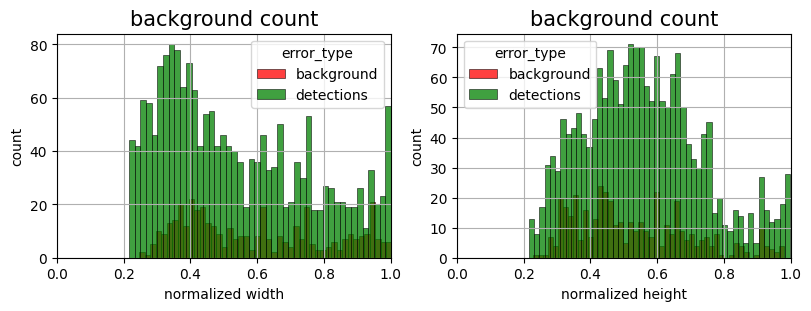

In [107]:
selected_column = 'background' # 'correct', 'localization', 'background', 'not detected' 중 택1

hue_order = ['target', selected_column]
order = class_names

temp_df = df[(df['error_type'] == selected_column)]
total_df = df[(df['error_type'].isin(['correct', 'localization', 'background']))] # 총 detection 대비 selected_column 시각화

fig, axes = plt.subplots(1, 2, figsize=(8,3), constrained_layout=True)
xlim = [0, 1]

sns.histplot(data=temp_df, x='gt_w', bins=50, color='red', ax=axes[0], label=f'{selected_column}')
sns.histplot(data=total_df, x='gt_w', bins=50, color='green',ax=axes[0], label='detections')
axes[0].set_xlabel('normalized width', fontsize=10)
axes[0].set_ylabel('count', fontsize=10)
axes[0].set_xlim(xlim)
axes[0].set_title(f'{selected_column} count', fontsize=15)
axes[0].legend(title='error_type')
axes[0].grid(True, axis='both')

sns.histplot(data=temp_df, x='gt_h', bins=50, color='red', ax=axes[1], label=f'{selected_column}')
sns.histplot(data=total_df, x='gt_h', bins=50, color='green', ax=axes[1], label='detections')
axes[1].set_xlabel('normalized height', fontsize=10)
axes[1].set_ylabel('count', fontsize=10)
axes[1].set_xlim(xlim)
axes[1].set_title(f'{selected_column} count', fontsize=15)
axes[1].legend(title='error_type')
axes[1].grid(True, axis='both')

## grid cell별로 bbox폭에 의한 분포 확인

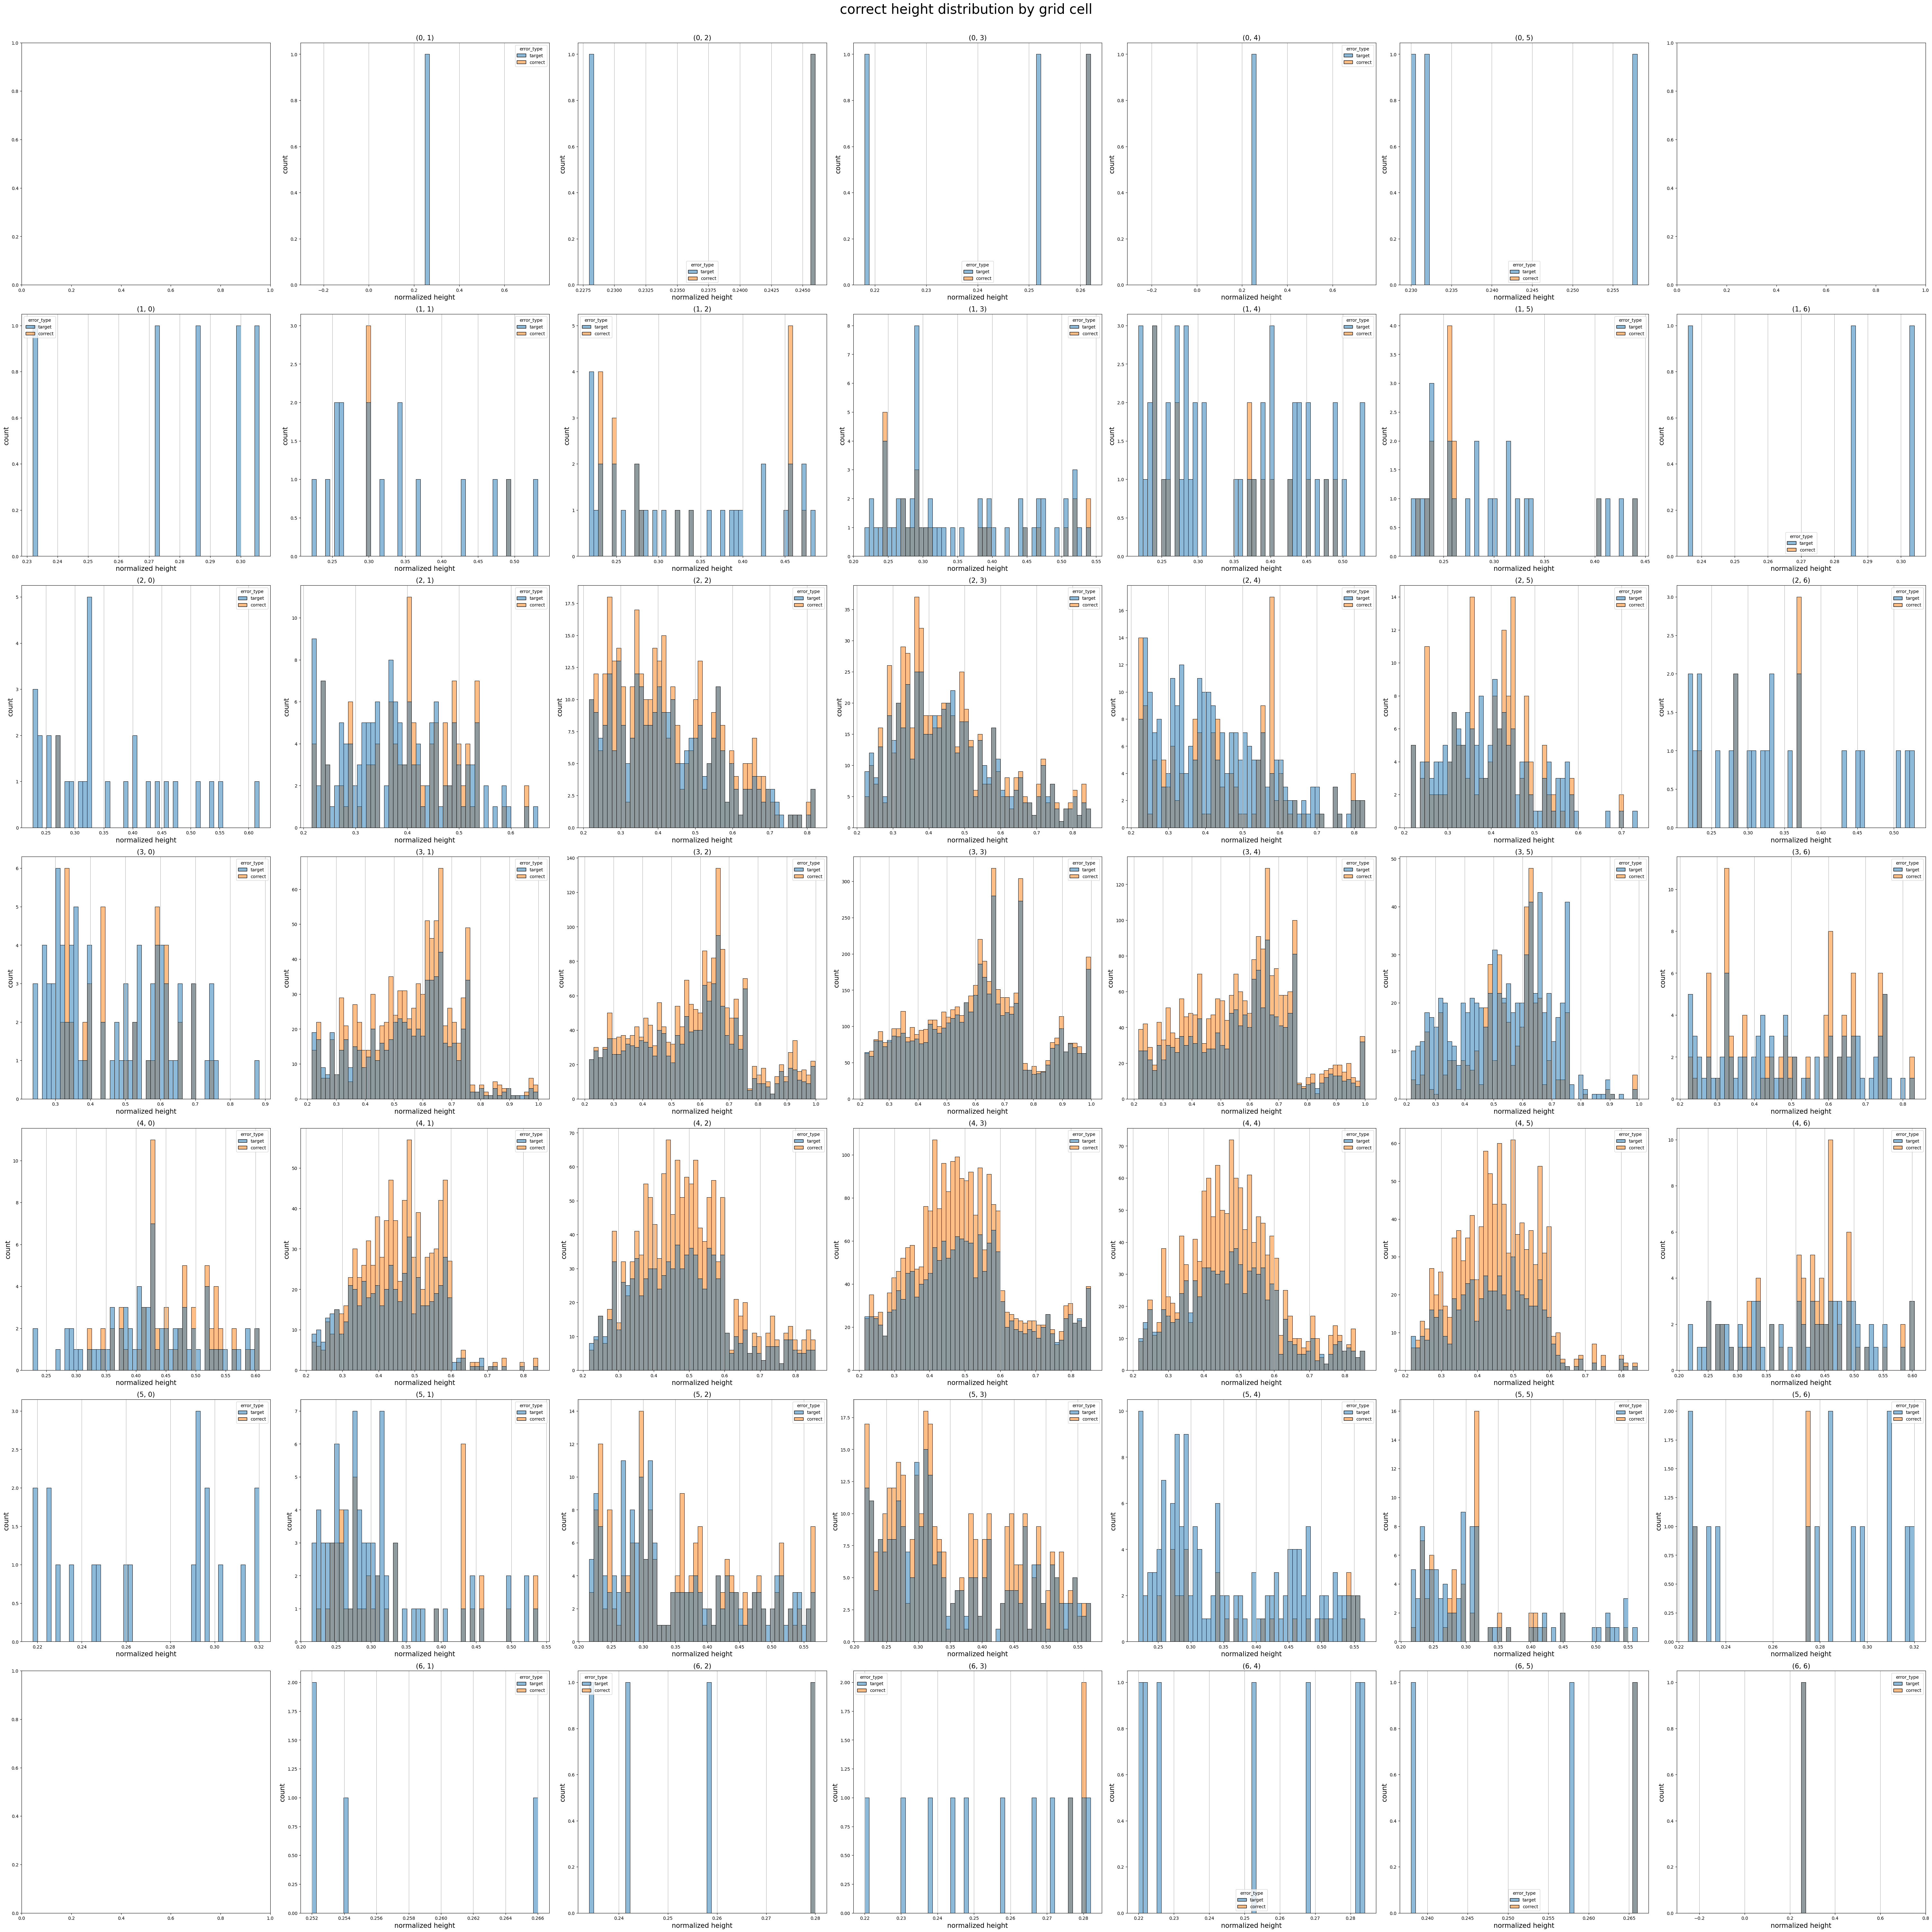

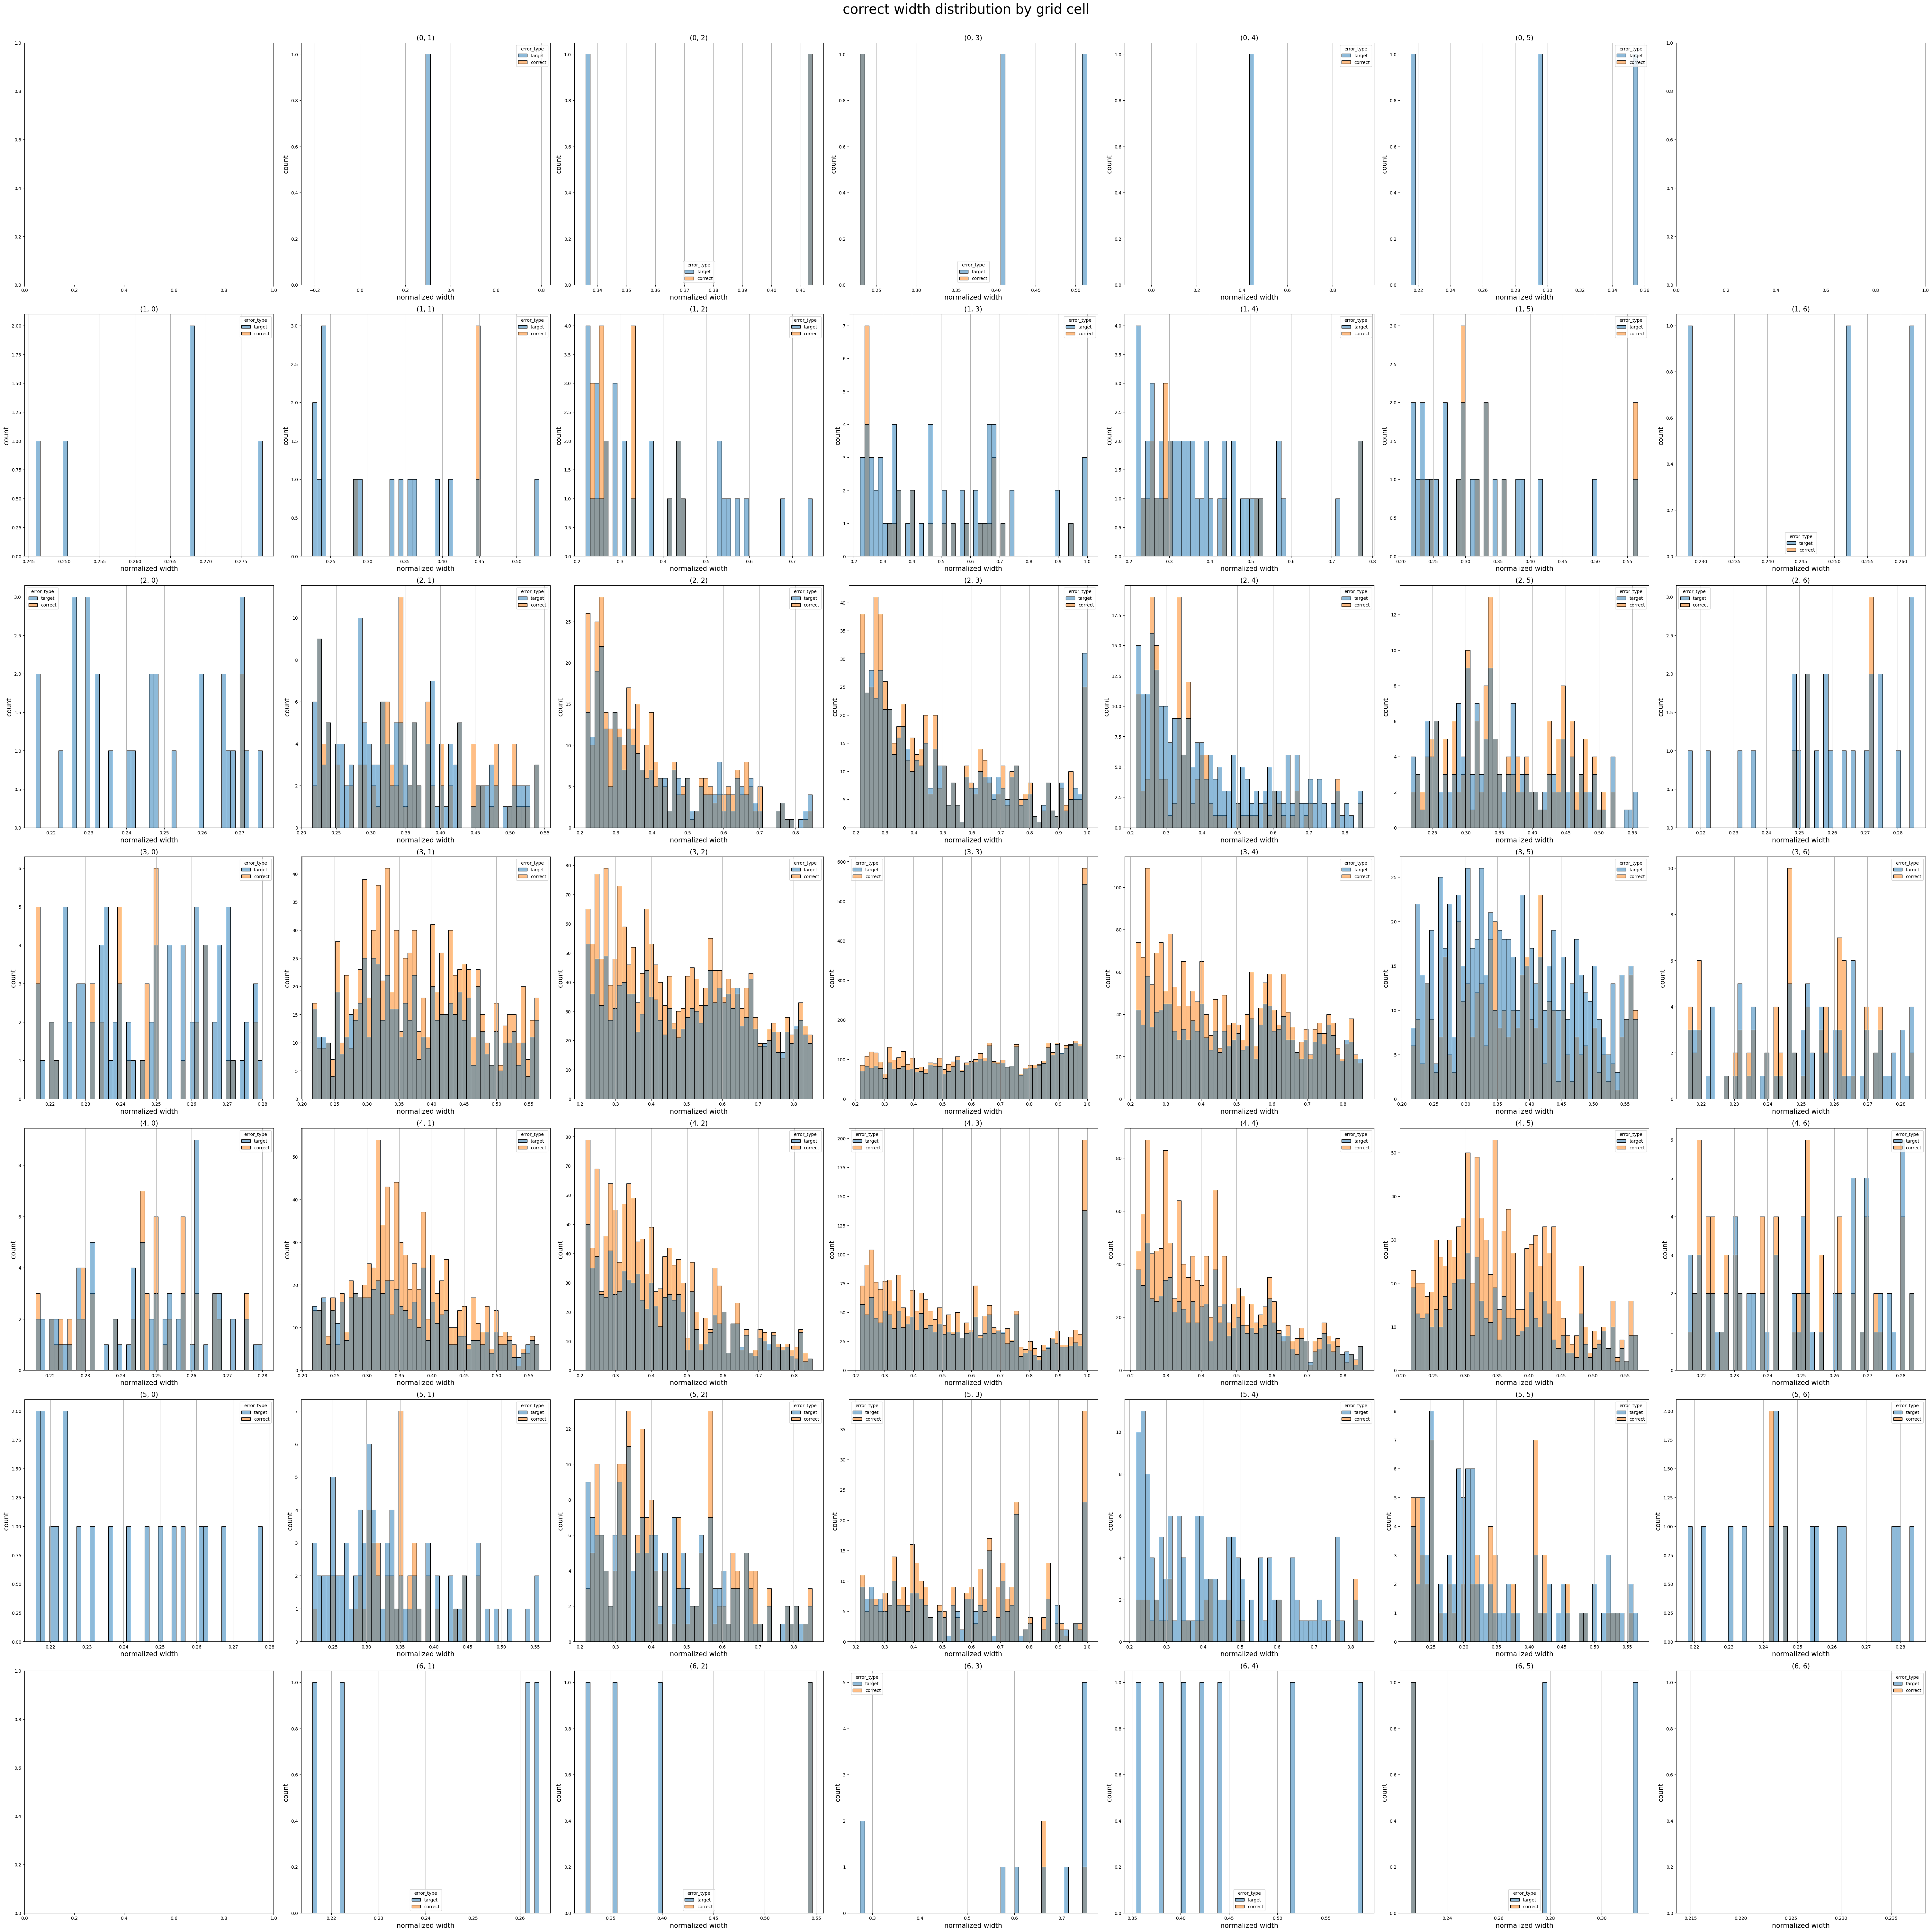

In [86]:
# height
S = 7
selected_column = 'correct' # 'correct', 'localization', 'background', 'not detected' 중 택1

hue_order = ['target', selected_column]
order = class_names

temp_df = df[(df['error_type'] == selected_column) | (df['error_type'] == 'target')]
fig, axes = plt.subplots(S, S, figsize=(60,60), constrained_layout=True)
plt.suptitle(f'{selected_column} height distribution by grid cell\n', fontsize=30)
xlim = [0, 1]

for i in range(S):
    for j in range(S):
        temp2_df = temp_df[(temp_df['gt_i'] == i) & (temp_df['gt_j'] == j)]
        if len(temp2_df) == 0:
            continue
        sns.histplot(data=temp2_df, x='gt_h', bins=50, hue='error_type', hue_order=hue_order, ax=axes[i][j])
        axes[i][j].set_xlabel('normalized height', fontsize=15)
        axes[i][j].set_ylabel('count', fontsize=15)
        axes[i][j].set_title(f'({i}, {j})', fontsize=15)
        axes[i][j].grid(True, axis='x')


# width
temp_df = df[(df['error_type'] == selected_column) | (df['error_type'] == 'target')]
fig, axes = plt.subplots(S, S, figsize=(60,60), constrained_layout=True)
plt.suptitle(f'{selected_column} width distribution by grid cell\n', fontsize=30)
xlim = [0, 1]

for i in range(S):
    for j in range(S):
        temp2_df = temp_df[(temp_df['gt_i'] == i) & (temp_df['gt_j'] == j)]
        if len(temp2_df) == 0:
            continue
        sns.histplot(data=temp2_df, x='gt_w', bins=50, hue='error_type', hue_order=hue_order, ax=axes[i][j])
        axes[i][j].set_xlabel('normalized width', fontsize=15)
        axes[i][j].set_ylabel('count', fontsize=15)
        axes[i][j].set_title(f'({i}, {j})', fontsize=15)
        axes[i][j].grid(True, axis='x')

## 특정 클래스의 bbox 분포 확인

In [56]:
class_names # 클래스명 확인

['AEROPLANE',
 'BICYCLE',
 'BIRD',
 'BOAT',
 'BOTTLE',
 'BUS',
 'CAR',
 'CAT',
 'CHAIR',
 'COW',
 'DININGTABLE',
 'DOG',
 'HORSE',
 'MOTORBIKE',
 'PERSON',
 'POTTEDPLANT',
 'SHEEP',
 'SOFA',
 'TRAIN',
 'TVMONITOR']

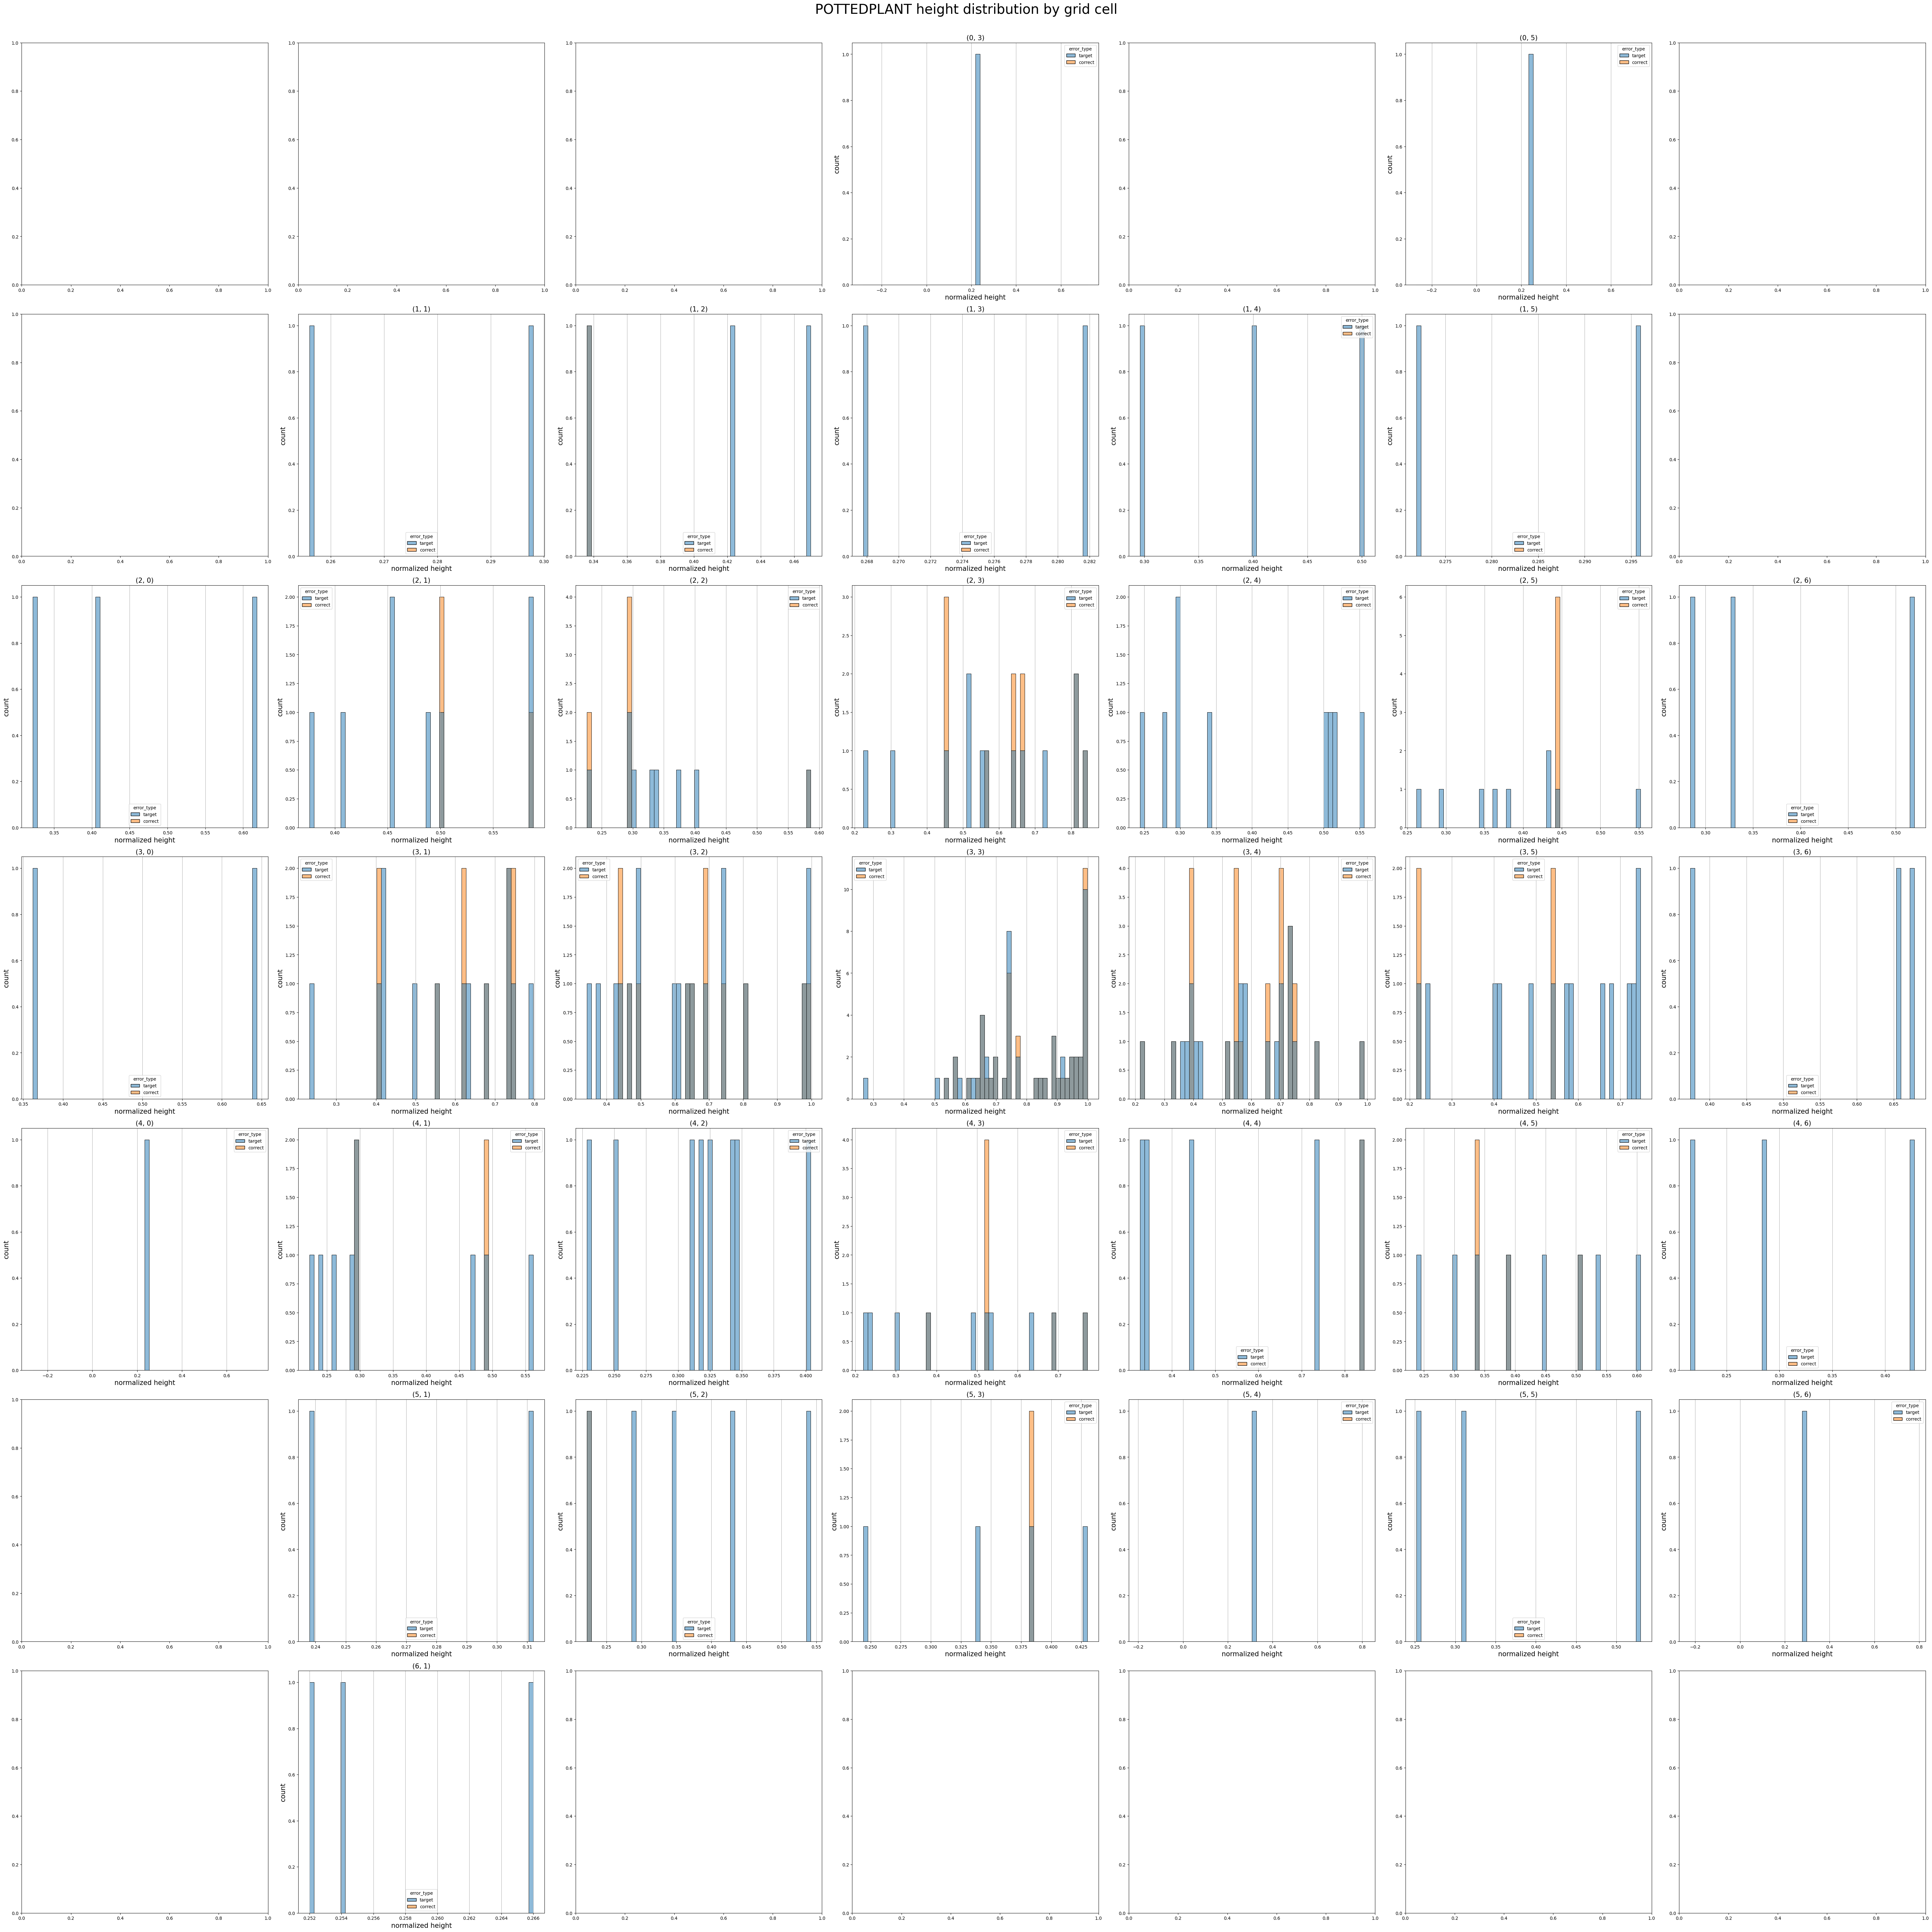

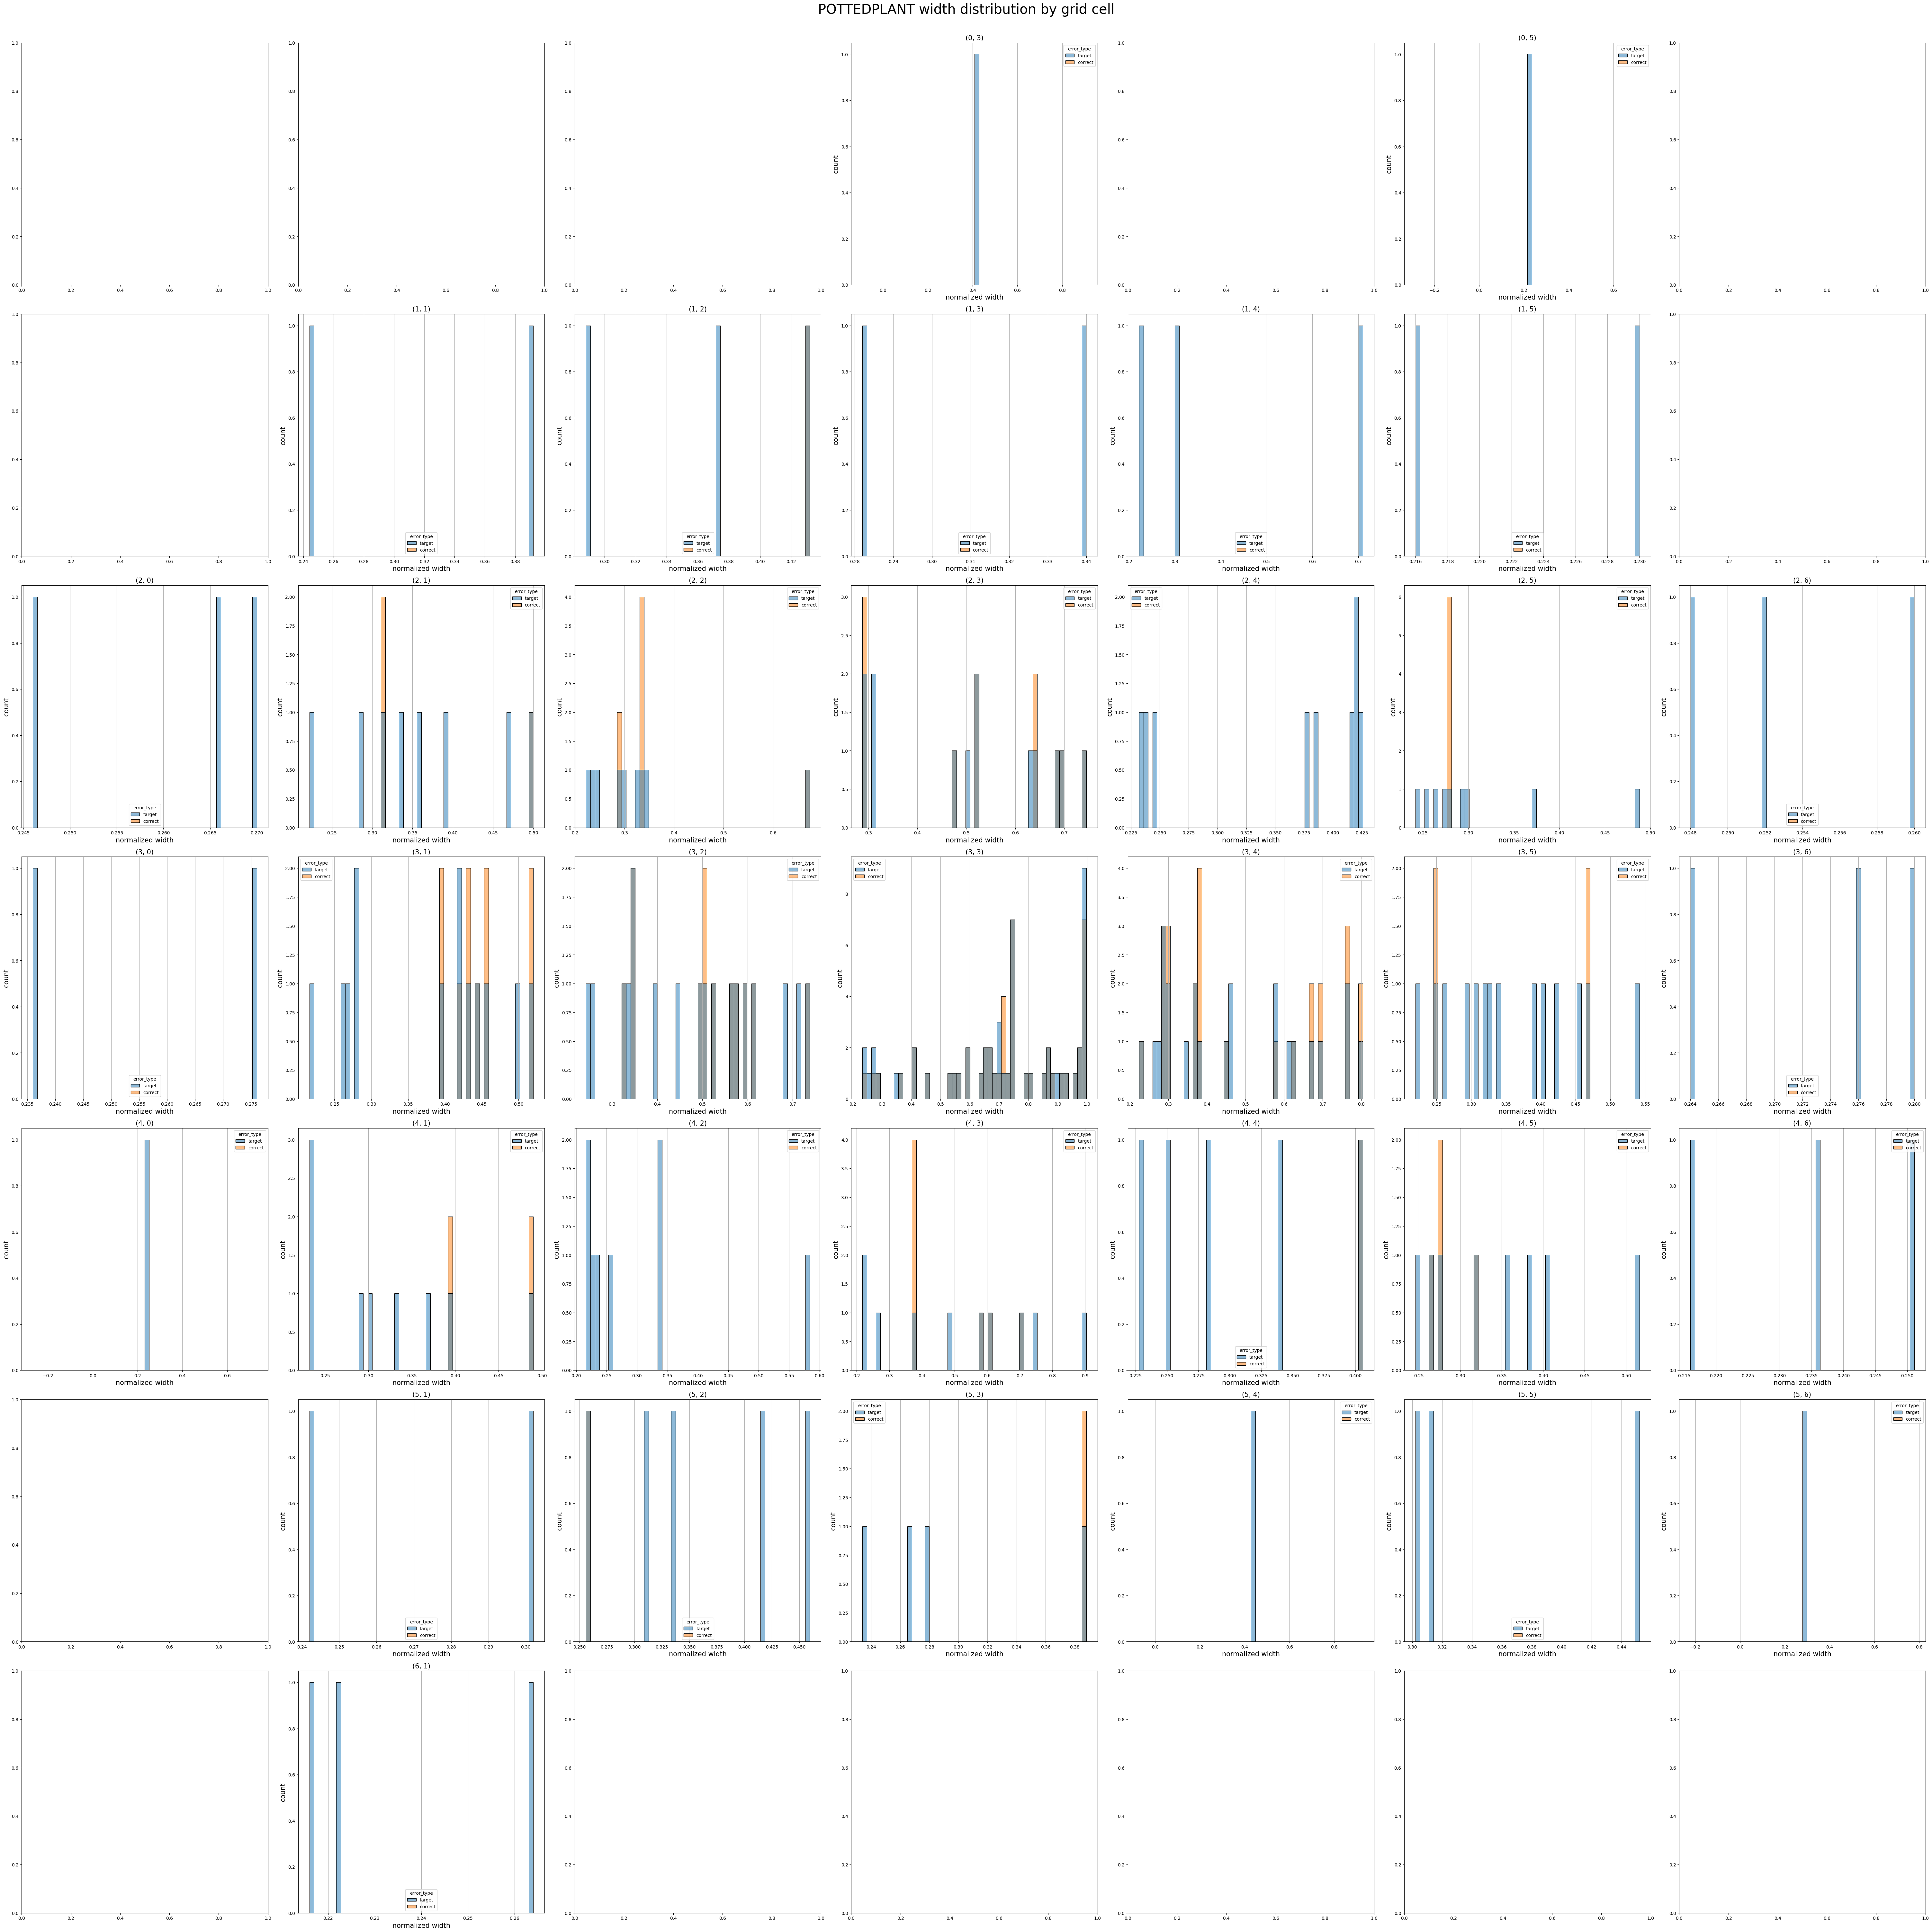

In [92]:
S = 7
selected_column = 'correct' # 'correct', 'localization', 'background', 'not detected' 중 택1
selected_class = class_names[15] # 클래스 택1

hue_order = ['target', selected_column]
order = class_names

temp_df = df[((df['error_type'] == selected_column) & (df['gt_class_name'] == selected_class)) |
             ((df['error_type'] == 'target') & (df['gt_class_name'] == selected_class))]
fig, axes = plt.subplots(S, S, figsize=(60,60), constrained_layout=True)
plt.suptitle(f'{selected_class} height distribution by grid cell\n', fontsize=30)
xlim = [0, 1]

for i in range(S):
    for j in range(S):
        temp2_df = temp_df[(temp_df['gt_i'] == i) & (temp_df['gt_j'] == j)]
        if len(temp2_df) == 0:
            continue
        sns.histplot(data=temp2_df, x='gt_h', bins=50, hue='error_type', hue_order=hue_order, ax=axes[i][j])
        axes[i][j].set_xlabel('normalized height', fontsize=15)
        axes[i][j].set_ylabel('count', fontsize=15)
        axes[i][j].set_title(f'({i}, {j})', fontsize=15)
        axes[i][j].grid(True, axis='x')



temp_df = df[((df['error_type'] == selected_column) & (df['gt_class_name'] == selected_class)) |
             ((df['error_type'] == 'target') & (df['gt_class_name'] == selected_class))]
fig, axes = plt.subplots(S, S, figsize=(60,60), constrained_layout=True)
plt.suptitle(f'{selected_class} width distribution by grid cell\n', fontsize=30)
xlim = [0, 1]

for i in range(S):
    for j in range(S):
        temp2_df = temp_df[(temp_df['gt_i'] == i) & (temp_df['gt_j'] == j)]
        if len(temp2_df) == 0:
            continue
        sns.histplot(data=temp2_df, x='gt_w', bins=50, hue='error_type', hue_order=hue_order, ax=axes[i][j])
        axes[i][j].set_xlabel('normalized width', fontsize=15)
        axes[i][j].set_ylabel('count', fontsize=15)
        axes[i][j].set_title(f'({i}, {j})', fontsize=15)
        axes[i][j].grid(True, axis='x')

## 시각적 분석

In [ ]:
# 이미지 순차적으로 살펴보기

import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from utils import draw, set_color
import albumentations as A
from albumentations.pytorch import ToTensorV2

df = pd.read_csv(csv_path)

test_transform = A.Compose([
    A.Normalize(mean=config.mean, std=config.std, max_pixel_value=255),
    A.LongestMaxSize(max_size=config.img_size),
    A.PadIfNeeded(
        min_height=config.img_size,
        min_width=config.img_size,
        border_mode=cv2.BORDER_CONSTANT,
    ),
    ToTensorV2(),
])

class_names = config.voc_classes
colors = set_color(len(class_names))

for train_idx in tqdm(range(0, int(df['train_idx'].max())+1)):
    temp_df = df[df['train_idx'] == train_idx]

    img_path = temp_df['img_path'].values[0]
    image = np.array(Image.open(img_path).convert('RGB'))

    augmentations = test_transform(image=image)
    image = augmentations['image']

    gt_df = temp_df.iloc[:, 2:8]
    gt_df.columns = ['class', 'confidence', 'x', 'y', 'w', 'h']
    gt_df['error_type'] = 'target'

    dt_df = temp_df.iloc[:, 8:14]
    dt_df.columns = ['class', 'confidence', 'x', 'y', 'w', 'h']
    dt_df['error_type'] = temp_df.iloc[:, 15]

    bboxes= pd.concat([gt_df, dt_df]).values

    save_dir = './images'
    file_name = img_path.split('\\')[-1]
    save_path = os.path.join(save_dir, file_name)

    draw(image, bboxes, class_names, colors, config.mean, config.std, analysis=True)
    # save_img(image, bboxes, class_names, colors, config.mean, config.std, analysis=True, save_path=save_path)

In [69]:
# 조건 설정하여 살펴보기

import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from utils import draw, set_color
import albumentations as A
from albumentations.pytorch import ToTensorV2

df = pd.read_csv(csv_path)
class_names = config.voc_classes
df['gt_i'] = (7 * df['gt_y']).astype(int)
df['gt_j'] = (7 * df['gt_x']).astype(int)
df['dt_i'] = (7 * df['dt_y']).astype(int)
df['dt_j'] = (7 * df['dt_x']).astype(int)
for i in range(len(df)):
    df.loc[i, 'gt_class_name'] = class_names[int(df.loc[i, 'gt_class'])]
    df.loc[i, 'dt_class_name'] = class_names[int(df.loc[i, 'dt_class'])]

# 조건 설정
selected_column = 'not detected' # 'correct', 'localization', 'background', 'not detected' 중 택1
selected_class = 2 # 클래스 택1
grid_indices = [[i, j] for i in range(7) for j in range(7)]
not_selected_grid = [24, 31]

df = df[((df['error_type'] == selected_column) & (df['gt_class'] == selected_class))]

test_transform = A.Compose([
    A.Normalize(mean=config.mean, std=config.std, max_pixel_value=255),
    A.LongestMaxSize(max_size=config.img_size),
    A.PadIfNeeded(
        min_height=config.img_size,
        min_width=config.img_size,
        border_mode=cv2.BORDER_CONSTANT,
    ),
    ToTensorV2(),
])

class_names = config.voc_classes
colors = set_color(len(class_names))

for i in range(49):
    if i in not_selected_grid:
        continue
    
    t_df = df[(df['gt_i'] == grid_indices[i][0]) & (df['gt_j'] == grid_indices[i][1])]
    train_idxs = t_df['train_idx'].unique()
    for train_idx in train_idxs:
        temp_df = t_df[t_df['train_idx'] == train_idx]

        img_path = temp_df['img_path'].values[0]
        image = np.array(Image.open(img_path).convert('RGB'))

        augmentations = test_transform(image=image)
        image = augmentations['image']

        gt_df = temp_df.iloc[:, 2:8]
        gt_df.columns = ['class', 'confidence', 'x', 'y', 'w', 'h']
        gt_df['error_type'] = 'target'

        dt_df = temp_df.iloc[:, 8:14]
        dt_df.columns = ['class', 'confidence', 'x', 'y', 'w', 'h']
        dt_df['error_type'] = temp_df.iloc[:, 15]

        bboxes= pd.concat([gt_df, dt_df]).values

        save_dir = './images'
        file_name = img_path.split('\\')[-1]
        save_path = os.path.join(save_dir, file_name)

        draw(image, bboxes, class_names, colors, config.mean, config.std, analysis=True)
        # save_img(image, bboxes, class_names, colors, config.mean, config.std, analysis=True, save_path=save_path)


C:\Users\K\AppData\Local\Temp\ipykernel_8576\2217760100.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt_df['error_type'] = 'target'
C:\Users\K\AppData\Local\Temp\ipykernel_8576\2217760100.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_df['error_type'] = temp_df.iloc[:, 15]
C:\Users\K\AppData\Local\Temp\ipykernel_8576\2217760100.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c